# Checking if a pair of stocks is cointegrated

## Imports

In [1]:
import MetaTrader5 as mt5
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model      import LinearRegression
from statsmodels.tsa.stattools import adfuller
#import quiz_tests

### exibimos dads sobre o pacote MetaTrader5

In [2]:
# exibimos dads sobre o pacote MetaTrader5
print("MetaTrader5 package author : ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
print("MetaTrader5 package package: ",mt5.__package__)
print("MetaTrader5 package path   : ",mt5.__path__)
print("MetaTrader5 package file   : ",mt5.__file__) 

MetaTrader5 package author :  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.33
MetaTrader5 package package:  MetaTrader5
MetaTrader5 package path   :  ['C:\\Users\\Usuario\\anaconda3\\lib\\site-packages\\MetaTrader5']
MetaTrader5 package file   :  C:\Users\Usuario\anaconda3\lib\site-packages\MetaTrader5\__init__.py


In [3]:
# Initializing MT5 connection 
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
print("MetaTrader5 terminal_info():", mt5.terminal_info())
print("MetaTrader5 version()      :", mt5.version()      )

MetaTrader5 terminal_info(): TerminalInfo(community_account=True, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=2776, maxbars=5000, codepage=1252, ping_last=281221, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='Portuguese (Brazil)', path='D:\\programs\\metatrader\\desen', data_path='C:\\Users\\Usuario\\AppData\\Roaming\\MetaQuotes\\Terminal\\1359089FFD8DE572A105C49A845B99B2', commondata_path='C:\\Users\\Usuario\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
MetaTrader5 version()      : (500, 2776, '05 Feb 2021')


### imprimimos informacoes sobre o estado da conexao, o nome do servidor e a conta de negociacao

In [4]:
#print("MetaTrader5 terminal_info():", mt5.terminal_info())
#print("MetaTrader5 version()      :", mt5.version()      )

In [4]:
# obtemos o número de instrumentos financeiros
symbols=mt5.symbols_total()
if symbols>0:
    print("Total symbols =",symbols)
else:
    print("Symbols not found")

Total symbols = 131


In [7]:
# obtemos todos os símbolos
symbols=mt5.symbols_get()
print('Symbols: ', len(symbols))
count=0
# exibimos os 5 primeiros
for s in symbols:
    count+=1
    print("{}. {}".format(count,s.name))
    if count==5: break

Symbols:  131
1. EURUSD
2. GBPUSD
3. USDCHF
4. USDJPY
5. USDCNH


In [5]:
# obtemos símbolos cujos nomes contêm RU
ru_symbols=mt5.symbols_get("*RU*")
print('len(*RU*): ', len(ru_symbols))
for s in ru_symbols:
    print(s.name)

len(*RU*):  10
EURUSD
USDRUB
USDRUR
EURRUR
EURRUB
BTCRUB
ETHRUB
LTCRUB
XMRUSD
XBRUSD


In [6]:
# obtemos símbolos cujos nomes não contêm USD, EUR, JPY e GBP
group_symbols=mt5.symbols_get(group="*,!*USD*,!*EUR*,!*JPY*,!*GBP*")
print('len(*,!*USD*,!*EUR*,!*JPY*,!*GBP*):', len(group_symbols))
for s in group_symbols:
    print(s.name )

len(*,!*USD*,!*EUR*,!*JPY*,!*GBP*): 47
AUDCAD
AUDCHF
AUDNZD
CADCHF
XAUAUD
NZDCAD
NZDCHF
NZDSGD
BTCCNH
BTCCNY
BTCRUB
ETCBTC
ETCETH
ETHBTC
ETHLTC
ETHRUB
LTCBTC
LTCCNH
LTCCNY
LTCRUB
CADMXN
CHFMXN
NZDMXN
AUS200
FCHI40
GDAXIm
HSI50
ND100m
NI225
SP500m
SPN35
STOX50
UK100
Brent
Crude
NatGas
BRENT_V0
WTI_U0
Cocoa_Z0
Coffee_Z0
Corn_U0
Cotton_Z0
OJ_U0
Soybean_U0
Sugar_V0
Wheat_U0
Wheat_Z0


In [7]:
#imprimimos as propriedades de um símbolo
def print_symbol_info(symbol):
    symbol_info=mt5.symbol_info(symbol)
    if symbol_info!=None:
        
        # exibimos os dados sobre o terminal tal qual como estão    
        #print(symbol_info)
        print(symbol , ":",        symbol_info.description,
                       "spread="  ,symbol_info.spread,
                       "digits="  ,symbol_info.digits,
                       "ask/bid=" ,symbol_info.ask,"/",symbol_info.bid,
                       "tick_value=" ,symbol_info.trade_tick_value,
                       "tick_size=" ,symbol_info.trade_tick_size
                       )
        
        if symbol_info.path.count('Equities') > 0:
            print("Eh uma acao:",symbol_info.path)
        
        # exibimos as propriedades do símbolo como uma lista
        print("Show symbol_info(",symbol,")._asdict():")
        symbol_info_dict = mt5.symbol_info(symbol)._asdict()
        for prop in symbol_info_dict:
            print("  {}={}".format(prop, symbol_info_dict[prop]))

In [8]:
#print_symbol_info("EURUSD")

In [8]:
# imprimimos o preco em 2005
def print_price(symbol,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_D1):
    symbol_info=mt5.symbol_info(symbol)
    if symbol_info!=None:
        
        # exibimos os dados sobre o terminal tal qual como estão    
        #print(symbol_info)
        print(symbol + ": spread =",symbol_info.spread,"  digits =",symbol_info.digits)
        
        if symbol_info.path.count('Equities') > 0:
            print("Eh uma acao:",symbol_info.path)

        # importamos o módulo pytz para trabalhar com o fuso horário
        import pytz        # definimos o fuso horário como UTC
        timezone = pytz.timezone("Etc/UTC")

        data = datetime(ano, mes, dia, tzinfo=timezone)
        # recebemos 10 barras de EURUSD H4 a partir de 01/10/2019 no fuso horário UTC
        rates = mt5.copy_rates_from(symbol, timeframe, data, qtd)
        # a partir dos dados recebidos criamos o DataFrame
        rates_frame = pd.DataFrame(rates)
        # convertemos o tempo em segundos para o formato datetime
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame.set_index("time")

        # exibimos dados
        print("\nExibimos o dataframe com dados")
        print(rates_frame)        

In [7]:
#print_price("EURUSD",2021,2,5,10)
#print_price("USDJPY",2021,2,5,10)


In [9]:
# imprimimos o preco nas datas informadas
def print_equity(symbol,anoIni,mesIni,diaIni,anoAtu,mesAtu,diaAtu):
    symbol_info=mt5.symbol_info(symbol)
    if symbol_info!=None:
        
        # exibimos os dados sobre o terminal tal qual como estão    
        #print(symbol_info)
        print(symbol ," ",symbol_info.description, ": spread =",symbol_info.spread,"  digits =",symbol_info.digits," path=",symbol_info.path)
        
        #if symbol_info.path.count('Equities') > 0:
        #    print("Eh uma acao:",symbol_info.path)

        # importamos o módulo pytz para trabalhar com o fuso horário
        import pytz        # definimos o fuso horário como UTC
        timezone = pytz.timezone("Etc/UTC")

        data = datetime(anoIni, mesIni, diaIni, tzinfo=timezone)
        # recebemos 1 barra do simbolo informado, na data informada e no fuso horário UTC
        rates = mt5.copy_rates_from(symbol, mt5.TIMEFRAME_D1, data, 1)
        # a partir dos dados recebidos criamos o DataFrame
        rates_frame_ini = pd.DataFrame(rates)
        # convertemos o tempo em segundos no formato datetime
        rates_frame_ini['time']=pd.to_datetime(rates_frame_ini['time'], unit='s')

        data = datetime(anoAtu, mesAtu, diaAtu, tzinfo=timezone)
        # recebemos 1 barra do simbolo informado, na data informada e no fuso horário UTC
        rates = mt5.copy_rates_from(symbol, mt5.TIMEFRAME_D1, data, 1)
        # a partir dos dados recebidos criamos o DataFrame
        rates_frame_atu = pd.DataFrame(rates)
        # convertemos o tempo em segundos no formato datetime
        rates_frame_atu['time']=pd.to_datetime(rates_frame_atu['time'], unit='s')

        #print(rates_frame_ini)
        #print(rates_frame_atu)
        print(rates_frame_atu-rates_frame_ini)

        rates_frame_ini
        
        # exibimos dados
        #print("\nExibimos o dataframe com dados")
        #print(rates_frame_ini)        
        #print(rates_frame_atu)

        #dict = {"dtIni"  : rates_frame_ini['time' ],
        #        "buy"    : rates_frame_ini['close'],
        #        "sell"   : rates_frame_atu['close'],
        #        "retAbs" :  (rates_frame_atu['close'] - rates_frame_ini['close'])                         ,
        #        "retPorc": ((rates_frame_atu['close'] - rates_frame_ini['close'])/rates_frame_ini['close'] )*100
        #       }

        #print_dict(dict)



In [12]:
def print_dict(dict): 
    for prop in dict:
        print("  {}={}".format(prop, dict[prop]))

In [9]:
#print_equity("EURUSD",2005,2,1,2020,12,12)

In [10]:
# imprimimos o preco em 2005
def get_ticker_data(symbol,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_D1):
    symbol_info=mt5.symbol_info(symbol)
    if symbol_info!=None:
        
        # exibimos os dados sobre o terminal tal qual como estão    
        #print(symbol_info)
        #print(symbol + ": spread =",symbol_info.spread,"  digits =",symbol_info.digits)
        
        #if symbol_info.path.count('Equities') > 0:
        #    print("Eh uma acao:",symbol_info.path)

        # importamos o módulo pytz para trabalhar com o fuso horário
        import pytz        # definimos o fuso horário como UTC
        timezone = pytz.timezone("Etc/UTC")

        dt = datetime(ano, mes, dia, tzinfo=timezone)
        # recebemos qtd barras de symbol a partir de dt no fuso horário UTC. As barras contam desde dt pra tras
        rates = mt5.copy_rates_from(symbol, timeframe, dt, qtd)
        # a partir dos dados recebidos criamos o DataFrame
        rates_frame = pd.DataFrame(rates)
        # convertemos o tempo em segundos para o formato datetime
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        #rates_frame.set_index("time")

        rates_frame["ticker"]=symbol

        return rates_frame



In [11]:
dfc = get_ticker_data("EURUSD",2021,2,15,3)
dfc

,time,open,high,low,close,tick_volume,spread,real_volume,ticker
0,2021-02-03,1.20423,1.20500,1.20042,1.20351,49377,0,0,EURUSD
1,2021-02-04,1.20349,1.20428,1.19574,1.19620,51807,0,0,EURUSD
2,2021-02-05,1.19618,1.20498,1.19522,1.20492,67841,0,0,EURUSD


In [11]:
# imprimimos o preco em 2005
def get_all_ticker_data(symbol,ano,mes,dia,qtd,timeframe=mt5.TIMEFRAME_D1, verbose=False):
    
    i=0
    for symb in symbol:
        if verbose:
            print("Obtendo", symb, i+1, "de", len(symbol), "...")

        dfs = get_ticker_data(symb,ano,mes,dia,qtd,timeframe)
        
        if i>0:
            dfall = dfall.append(dfs)
        else: 
            dfall = dfs
        i = i+1
    
    return dfall


In [13]:
dfa = get_all_ticker_data(["GBPUSD","EURUSD"],2021,2,15,3)
dfa


,time,open,high,low,close,tick_volume,spread,real_volume,ticker
0,2021-02-03,1.36669,1.36831,1.36193,1.36435,77118,0,0,GBPUSD
1,2021-02-04,1.36428,1.36977,1.35647,1.36715,81986,0,0,GBPUSD
2,2021-02-05,1.36715,1.37399,1.36603,1.37363,84121,0,0,GBPUSD
0,2021-02-03,1.20423,1.20500,1.20042,1.20351,49377,0,0,EURUSD
1,2021-02-04,1.20349,1.20428,1.19574,1.19620,51807,0,0,EURUSD
2,2021-02-05,1.19618,1.20498,1.19522,1.20492,67841,0,0,EURUSD


In [14]:
#dfo = dfa.pivot(index='time', columns='ticker', values='open')
#dfc = dfa.pivot(index='time', columns='ticker', values='close')
dfv = dfa.pivot(index='time', columns='ticker', values='tick_volume')
dfv


ticker,EURUSD,GBPUSD
time,,
2021-02-03,49377,77118
2021-02-04,51807,81986
2021-02-05,67841,84121


In [4]:
# obtemos todos os símbolos
symbols=mt5.symbols_get("* , !EURNOK, !EURRUR")
print('Symbols: ', len(symbols))
count=0
tickers = []
# exibimos os 5 primeiros
for s in symbols:
    count+=1
    #print("{}. {}".format(count,s.name))
    tickers.append(s.name)
    if count>38: break

dfa = get_all_ticker_data(tickers,2021,2,15,365,verbose=True)





TypeError: object of type 'NoneType' has no len()

In [2]:
dfa = pd.read_csv("dfa_d1_forex.csv")
dfa.dropna()
dfa

,Unnamed: 0,time,open,high,low,close,tick_volume,spread,real_volume,ticker
0,0,2019-09-10,1.10474,1.10593,1.10304,1.10432,41989,1,0,EURUSD
1,1,2019-09-11,1.10430,1.10555,1.09851,1.10102,38930,1,0,EURUSD
2,2,2019-09-12,1.10102,1.10870,1.09267,1.10643,66013,1,0,EURUSD
3,3,2019-09-13,1.10643,1.11094,1.10553,1.10697,51145,1,0,EURUSD
4,4,2019-09-16,1.10720,1.10863,1.09932,1.10003,47575,1,0,EURUSD
...,...,...,...,...,...,...,...,...,...,...
14230,360,2021-02-01,91.53200,92.07000,91.08000,91.93500,52792,27,0,EURRUB
14231,361,2021-02-02,91.63200,91.70500,90.61200,90.93200,49280,27,0,EURRUB
14232,362,2021-02-03,91.64000,91.67900,91.04400,91.28000,40429,27,0,EURRUB
14233,363,2021-02-04,90.85900,90.90600,90.25200,90.62000,40698,18,0,EURRUB


In [17]:
dfa.to_csv("dfa_forex.csv")

In [3]:
#dfo = dfa.pivot(index='time', columns='ticker', values='open')
dfc = dfa.pivot(index='time', columns='ticker', values='close')
dfv = dfa.pivot(index='time', columns='ticker', values='tick_volume')
dfc = dfc.dropna()
dfc


ticker,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CADJPY,CHFJPY,EURAUD,EURCAD,...,USDHUF,USDJPY,USDNOK,USDPLN,USDRUB,USDRUR,USDSEK,USDSGD,USDTRY,USDZAR
time,,,,,,,,,,,,,,,,,,,,,
2019-09-10,0.90215,0.68031,73.778,1.06762,0.68601,0.75404,81.761,108.384,1.60927,1.45232,...,300.240,107.541,8.95351,3.92150,65.43202,65.43202,9.68104,1.37946,5.76686,14.63890
2019-09-11,0.90497,0.68107,73.964,1.06984,0.68614,0.75241,81.699,108.558,1.60392,1.45250,...,301.610,107.810,8.95356,3.94090,65.40975,65.41365,9.67219,1.37865,5.74526,14.67730
2019-09-12,0.90680,0.67969,74.206,1.07091,0.68661,0.74950,81.815,109.126,1.61079,1.46115,...,300.500,108.095,8.97136,3.91683,64.86735,64.86950,9.62646,1.37399,5.65781,14.59750
2019-09-13,0.91345,0.68090,74.332,1.07834,0.68753,0.74495,81.330,109.115,1.60867,1.47057,...,298.910,108.073,8.98286,3.89770,64.20975,64.21124,9.60646,1.37304,5.68202,14.56200
2019-09-16,0.90864,0.68129,74.213,1.08159,0.68639,0.74962,81.651,108.878,1.60208,1.45617,...,301.680,108.129,8.95904,3.93430,63.95755,63.96103,9.65437,1.37447,5.72597,14.66010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.97850,0.68324,79.940,1.06443,0.76181,0.69755,81.613,116.929,1.58214,1.54902,...,295.000,104.922,8.59430,3.73815,76.11400,76.11400,8.42610,1.33261,7.18808,15.04715
2021-02-02,0.97215,0.68242,79.849,1.05742,0.76062,0.70185,82.121,116.953,1.58293,1.53919,...,294.990,104.968,8.59840,3.71876,75.63600,75.63000,8.39100,1.33050,7.19181,14.94875
2021-02-03,0.97382,0.68469,80.021,1.05660,0.76172,0.70299,82.138,116.810,1.57963,1.53859,...,294.990,105.029,8.58510,3.72645,76.03800,76.03800,8.39845,1.33268,7.15205,14.93047


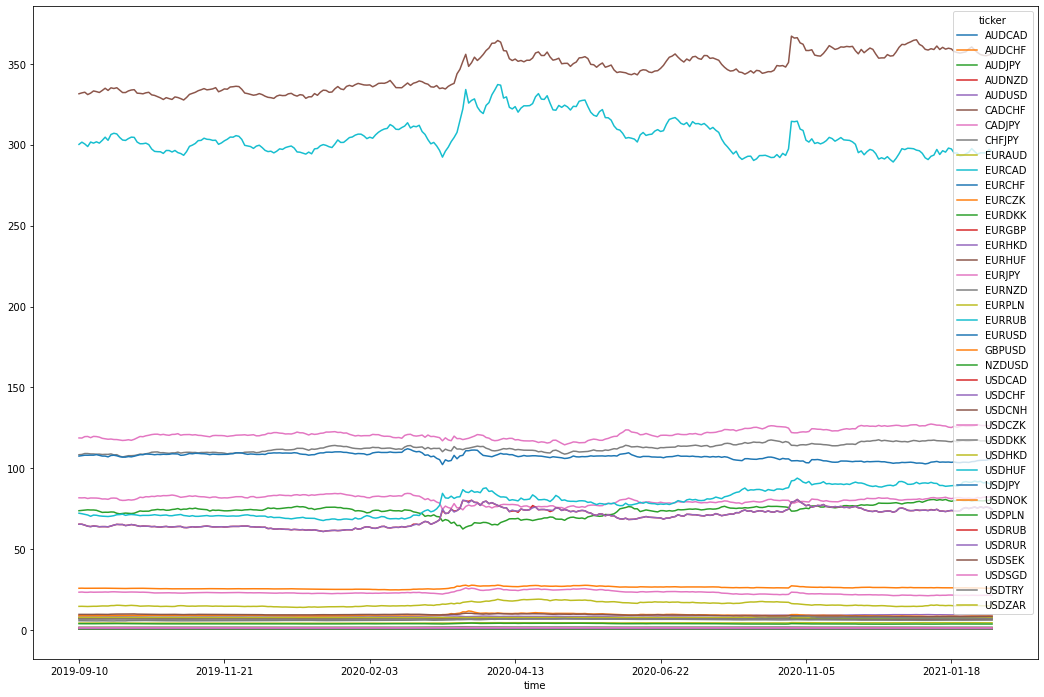

In [4]:
dfc.plot(figsize=(18,12))

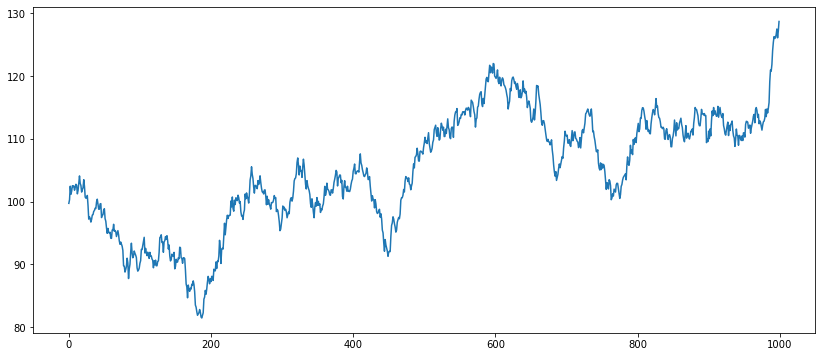

In [26]:
# just set the seed for the random number generator
np.random.seed(2018)
# use returns to create a price series
drift = 100
r1 = np.random.normal(0, 1, 1000) 
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.plot(figsize=(14,6))
plt.show()

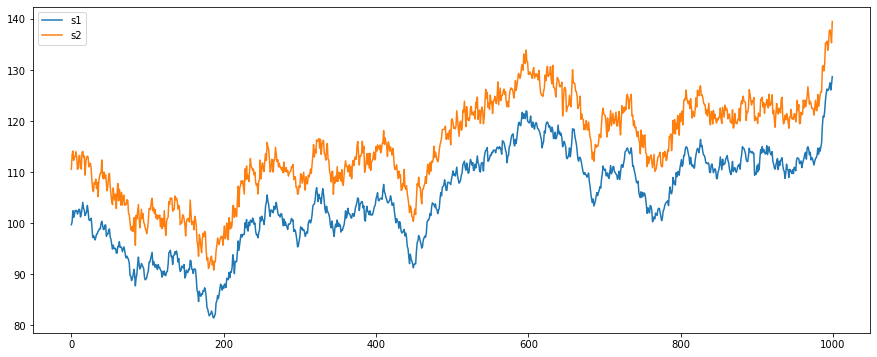

In [4]:
offset = 10
noise = np.random.normal(0, 1, 1000)
s2 = s1 + offset + noise
s2.name = 's2'
pd.concat([s1, s2], axis=1).plot(figsize=(15,6))
plt.show()

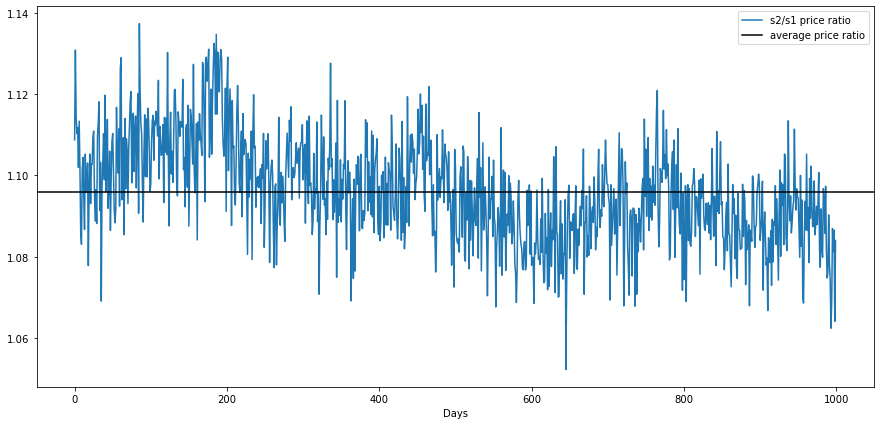

average price ratio 1.0960


In [5]:
price_ratio = s2/s1
price_ratio.plot(figsize=(15,7)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

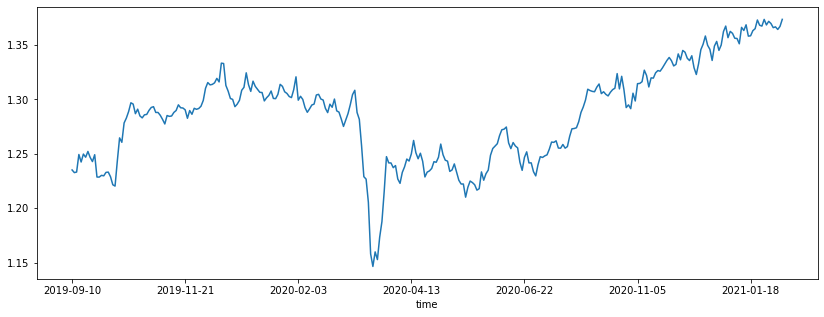

In [5]:
s1 = dfc["GBPUSD"]
s1.plot(figsize=(14,5))
plt.show()

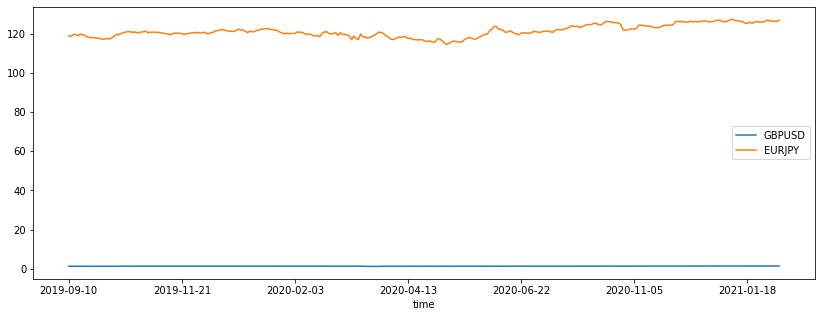

In [6]:
s2 = dfc["EURJPY"]
s2.name = 'EURJPY'
pd.concat([s1, s2], axis=1).plot(figsize=(14,5))
plt.show()

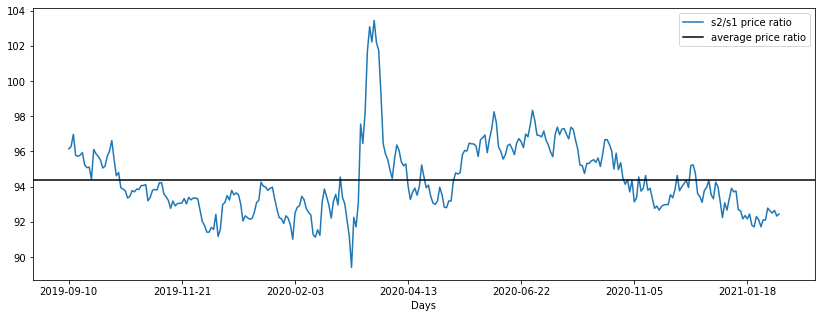

average price ratio 94.3846


In [7]:
price_ratio = s2/s1
price_ratio.plot(figsize=(14,5)) 
plt.axhline(price_ratio.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print(f"average price ratio {price_ratio.mean():.4f}")

## Calculate hedge ratio with regression

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays


Observe que LinearRegression().fit() espera matrizes numpy 2D. Como s1 e s2 são séries pandas, podemos usar Series.values para obter os valores como uma matriz numpy. Como esses são arrays 1D, podemos usar numpy.reshape (-1,1) para tornar esses arrays bidimensionais de 1000 linhas por 1 coluna.

In [40]:
type(s1)

pandas.core.series.Series

In [41]:
type(s1.values)

numpy.ndarray

In [114]:
s1=s1.dropna()
s2=s2.dropna()

In [55]:
s2

time
2019-09-10    1.10432
2019-09-11    1.10102
2019-09-12    1.10643
2019-09-13    1.10697
2019-09-16    1.10003
               ...   
2021-02-01    1.20594
2021-02-02    1.20428
2021-02-03    1.20351
2021-02-04    1.19620
2021-02-05    1.20492
Name: EURUSD, Length: 365, dtype: float64

In [115]:
s1.values.reshape(-1,1).shape

(365, 1)

In [116]:
lr = LinearRegression()
lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))

LinearRegression()

In [117]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

56.677328824240675

In [118]:
intercept = lr.intercept_[0]
intercept

48.738732048548

In [119]:
print(f"hedge ratio from regression is {hedge_ratio:.4f}, intercept is {intercept:.4f}")

hedge ratio from regression is 56.6773, intercept is 48.7387


 ## Question
 Do you think we'll need the intercept when calculating the spread?  Why or why not?
 
 Você acha que precisaremos da interceptação ao calcular o spread? Por que ou por que não?

## Calculate the spread

In [120]:
spread = s2 - s1 * hedge_ratio

In [63]:
#spread

In [121]:
print(f"Average spread is {spread.mean()}")

Average spread is 48.73873204854804


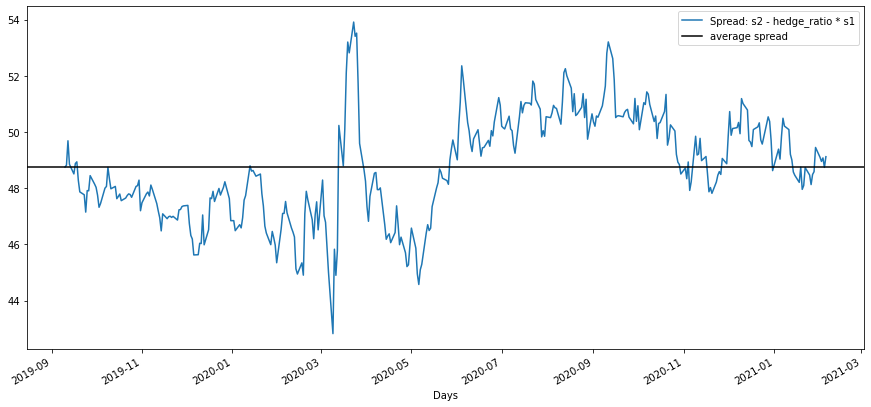

In [122]:
spread.plot(figsize=(15,7)) 
plt.axhline(spread.mean(), color='black') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

## Let's see what we get if we include the intercept of the regression

Vamos ver o que temos se incluirmos o intercepto da regressão

In [123]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print(f"Average spread with intercept included is {spread_with_intercept.mean()}")

Average spread with intercept included is -1.1680154560440002e-16


In [1]:
spread_with_intercept.plot(figsize=(15,7)) 
plt.axhline(spread_with_intercept.mean(), color='black') 
plt.axhline((spread_with_intercept - spread_with_intercept.mean())/spread_with_intercept.std(), color='blue') 
plt.xlabel('Days')
plt.legend(['Spread: s2 - (hedge_ratio * s1 + intercept)', 'average spread'])
plt.show()

NameError: name 'spread_with_intercept' is not defined

## Quiz
### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [125]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    #TODO: use the adfuller function to check the spread
    adf_result = adfuller(spread)
    
    #get the p-value
    pvalue = adf_result[1]
    
    print(f"pvalue {pvalue:.4f}")
    if pvalue <= p_level:
        print(f"pvalue is <= {p_level}, assume spread is stationary")
        return True
    else:
        print(f"pvalue is > {p_level}, assume spread is not stationary")
        return False
    
#quiz_tests.test_is_spread_stationary(is_spread_stationary)

In [126]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread)}")

pvalue 0.1945
pvalue is > 0.05, assume spread is not stationary
Are the two series candidates for pairs trading? False


In [127]:
# Try out your function
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(spread_with_intercept)}")

pvalue 0.1945
pvalue is > 0.05, assume spread is not stationary
Are the two series candidates for pairs trading? False


In [128]:
# Try out your function
price_ratio = price_ratio.dropna()
print(f"Are the two series candidates for pairs trading? {is_spread_stationary(price_ratio)}")

pvalue 0.0002
pvalue is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True


1. construa uma função () que recebe 2 series de precos e retorna o p-valor da razao entre as duas series.
2. 

In [14]:
def calc_edge_spread(s1,s2):
    s1.values.reshape(-1,1).shape
    lr = LinearRegression()
    lr.fit(s1.values.reshape(-1,1),s2.values.reshape(-1,1))
    hedge_ratio = lr.coef_[0][0]
    intercept = lr.intercept_[0]
    spread = s2 - (s1 * hedge_ratio + intercept)
    return spread
            

In [17]:
def generate_long_short_candidates(dfc):
    # IN
    # dfc: DataFrame
    #   precos de fechamento por data e ativo
    #
    # OUT
    # dfls: DataFrame
    #   cada linha é um par de ativos com seu resultado do seu teste de estacionariedade
    #
    long_short = []
    for name1,data1 in dfc.dropna().items():
        for name2,data2 in dfc.dropna().items():

            # calculando o edge spread...
            spread = calc_edge_spread(data1,data2)
            #spread = data1/data2
            
            # calculando a estacionariedade do spread...
            adf_result = adfuller(spread)
            adf    = adf_result[0]
            pvalue = adf_result[1]
            long_short.append( [ name1,name2,adf,pvalue ] )

            # mantendo log na tela durante a execução...
            print(name1, name2, adf, pvalue)

    return pd.DataFrame(long_short, columns=['ticker1','ticker2','adf','pvalue'])


In [18]:
long_short = generate_long_short_candidates(dfc)

483
USDHUF EURCAD -1.6680268855747555 0.4476566768039787
USDHUF EURCHF -2.883330764111104 0.04732102418727693
USDHUF EURCZK -1.999045889096082 0.28699160018899167
USDHUF EURDKK -0.2643803555305695 0.9303998298406542
USDHUF EURGBP -2.0285945142241855 0.2741778175824158
USDHUF EURHKD -1.0147029029787658 0.7478640534301567
USDHUF EURHUF -0.9663554035560742 0.7653368090027617
USDHUF EURJPY -2.0487977890109303 0.2655950066517533
USDHUF EURNZD -3.2071454504842443 0.0195747802596314
USDHUF EURPLN -0.9277035056981522 0.7787124258323037
USDHUF EURRUB -1.0474306985016169 0.7355745824129757
USDHUF EURUSD -0.921535919848185 0.7807976295290485
USDHUF GBPUSD -2.6533799516647187 0.08245877927341377
USDHUF NZDUSD -1.6549039420882203 0.45448414504422197
USDHUF USDCAD -3.259997631056731 0.016764058793319804
USDHUF USDCHF -1.0262245963547063 0.7435797340392452
USDHUF USDCNH -1.1638296097609893 0.6889586469192637
USDHUF USDCZK -2.1132535397593557 0.2392187905080399
USDHUF USDDKK -0.8933062167687779 0.7901

In [20]:
#dfc.plot(figsize=(14,6))
long_short.to_csv  ("long_short_forex.csv")
long_short.to_excel("long_short_forex.xlsx")


In [30]:
def plot_symbols(dfc,str1,str2,shift1,shift2):
    s1 = dfc[str1]+shift1
    s2 = dfc[str2]+shift2
    s1.name = str1
    s2.name = str2
    pd.concat([s1, s2], axis=1).plot(figsize=(14,5))
    plt.show()

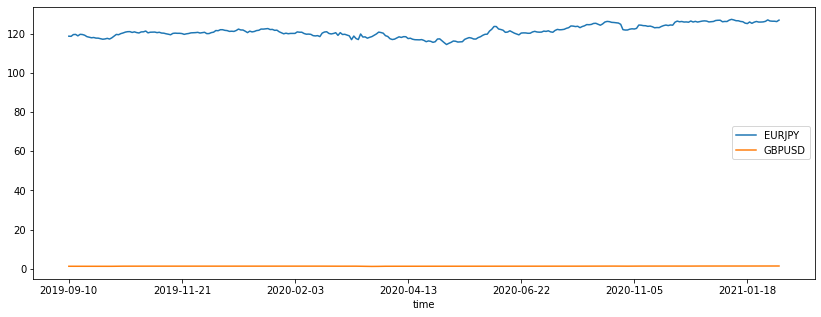

In [32]:
plot_symbols(dfc,"EURJPY","GBPUSD")

In [27]:
def plot_spread(spread):
    
    mean = spread.mean()
    std  = spread.std()
    zscore = ( ( spread - mean )/ std ).mean()
    
    spread.plot(figsize=(15,7))

    plt.axhline(mean  , color='black') 
    plt.axhline(zscore, color='blue' ) 
    plt.xlabel('Days')
    plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
    plt.show()

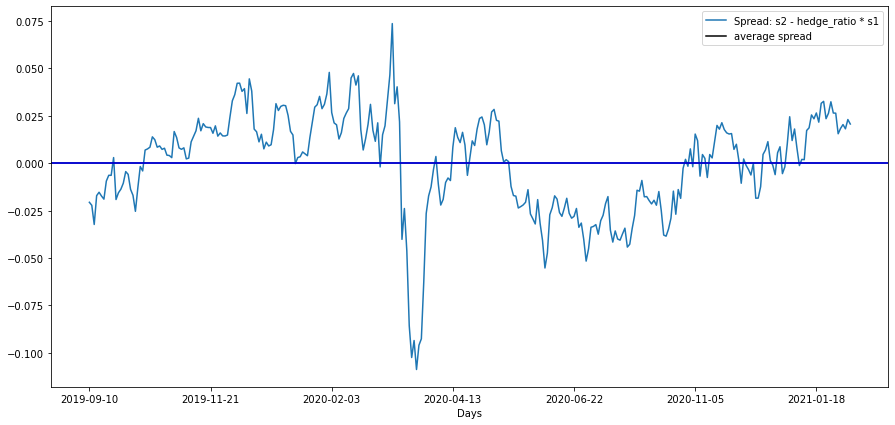

In [28]:
spread = calc_edge_spread( dfc["EURJPY"],dfc["GBPUSD"] )
plot_spread(spread)